<a href="https://colab.research.google.com/github/brenoslivio/MDNE_2024/blob/main/Project_1/Projeto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SCC5920 - Mineração de Dados Não Estruturados (2024)


**Projeto 1: Mineração de Textos - Classificação de Peptídeos Anti Câncer**

Prof. Ricardo Marcacini

**Aluno:** Breno Livio Silva de Almeida

**NUSP:** 10276675

---

Começamos instalando bibliotecas não disponíveis no Google Colab, como BioPython, usado para ler dados de sequências biológicas, e Optuna, um framework estado-da-arte para otimização Bayesiana.

In [1]:
!pip install biopython
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00


Em seguida importamos as bibliotecas que vamos usar.

In [2]:
from Bio import SeqIO
import requests, io
import polars as pl
import optuna
import numpy as np
from sklearn.svm import SVC
from itertools import product
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from transformers import T5EncoderModel, T5Tokenizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, matthews_corrcoef, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
import torch
import re
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

A partir do repositório do GitHub, convertemos os arquivos FASTA para um DataFrame do Polars. FASTA é um arquivo de texto, mas conhecido para armazenar sequências biológicas. BioPython é usado para ler os arquivos.

In [3]:
labels = ["anticancer", "non"]

df_seqs = pl.DataFrame()

for label in labels:
  response = requests.get(f"https://raw.githubusercontent.com/brenoslivio/MDNE_2024/refs/heads/main/Project_1/{label}.fasta")

  headers, seqs, labels = [], [], []

  if response.status_code == 200:
      handle = io.StringIO(response.text)
      for record in SeqIO.parse(handle, "fasta"):
          headers.append(record.description)
          seqs.append(str(record.seq))
  else:
      print(f"Failed to download file. Status code: {response.status_code}")

  df_seqs = pl.concat([df_seqs, pl.DataFrame({"header": headers, "sequence": seqs}).with_columns(label=pl.lit(label))])

df_seqs

header,sequence,label
str,str,str
"""ACP_1""","""GLWSKIKEVGKEAAKAAAKAAGKAALGAVS…","""anticancer"""
"""ACP_2""","""GLFDIIKKIAESI""","""anticancer"""
"""ACP_3""","""GLLDIVKKVVGAFGSL""","""anticancer"""
"""ACP_4""","""GLFDIVKKVVGALGSL""","""anticancer"""
"""ACP_5""","""GLFDIVKKVVGTLAGL""","""anticancer"""
…,…,…
"""non-ACP_202""","""TDTPLDLAIQQLQNLAIESIPDPPTNTPEA…","""non"""
"""non-ACP_203""","""LRLIHFLHQTTDPYPQGPGTANQRRRR""","""non"""
"""non-ACP_204""","""PVDTPLDLAIQQLQGLAIEELPDPPTSAPE…","""non"""


### Bag of Words



Aqui utilizamos a abordagem de Bag of Words, onde fazemos a contagem de aminoácidos nas sequências.

In [4]:
chars = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
            'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']

def dict_kmer(seq, k):
    counts = {''.join(comb): 0 for comb in product(chars, repeat= k)}
    L = len(seq)
    for i in range(L - k + 1):
        counts[seq[i:i+k]] += 1

    return counts

df_seqs_bow = df_seqs.with_columns(pl.col("sequence").map_elements(lambda x: dict_kmer(x, 1)).alias("aac")).unnest("aac")
df_seqs_bow

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


header,sequence,label,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V,X
str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""ACP_1""","""GLWSKIKEVGKEAAKAAAKAAGKAALGAVS…","""anticancer""",11,0,0,0,0,0,3,4,0,1,2,6,0,0,0,2,0,1,0,3,0
"""ACP_2""","""GLFDIIKKIAESI""","""anticancer""",1,0,0,1,0,0,1,1,0,4,1,2,0,1,0,1,0,0,0,0,0
"""ACP_3""","""GLLDIVKKVVGAFGSL""","""anticancer""",1,0,0,1,0,0,0,3,0,1,3,2,0,1,0,1,0,0,0,3,0
"""ACP_4""","""GLFDIVKKVVGALGSL""","""anticancer""",1,0,0,1,0,0,0,3,0,1,3,2,0,1,0,1,0,0,0,3,0
"""ACP_5""","""GLFDIVKKVVGTLAGL""","""anticancer""",1,0,0,1,0,0,0,3,0,1,3,2,0,1,0,0,1,0,0,3,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""non-ACP_202""","""TDTPLDLAIQQLQNLAIESIPDPPTNTPEA…","""non""",3,0,2,4,1,3,2,0,0,3,5,0,0,0,5,1,4,0,0,0,0
"""non-ACP_203""","""LRLIHFLHQTTDPYPQGPGTANQRRRR""","""non""",1,5,1,1,0,3,0,2,2,1,3,0,0,1,3,0,3,0,1,0,0
"""non-ACP_204""","""PVDTPLDLAIQQLQGLAIEELPDPPTSAPE…","""non""",3,0,1,4,0,3,3,1,0,2,6,0,0,0,7,1,2,0,0,2,0


Com a representação estruturada anterior, vamos utilizar o Optuna com o algoritmo SVM para maximizar a acurácia média usando 10-fold Cross-Validation.

In [5]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e3, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X, y, cv=10, scoring=make_scorer(f1_score, pos_label='anticancer'))

    return np.mean(scores)

X, y = df_seqs_bow.select(pl.nth(range(3, len(df_seqs_bow.columns)))).to_numpy(), df_seqs_bow["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study1 = optuna.create_study(direction="maximize", sampler=sampler)
study1.optimize(objective, n_trials=100)

print("Best hyperparameters:", study1.best_params)
print(f"Best F1-score: {study1.best_value:.4f}")

[I 2024-09-29 20:06:14,325] A new study created in memory with name: no-name-8e704b3b-7241-49e5-bb85-241c0f0d22eb
[I 2024-09-29 20:06:14,496] Trial 0 finished with value: 0.5214806838067034 and parameters: {'svm_C': 0.0869604013210559, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.5214806838067034.
[I 2024-09-29 20:06:14,646] Trial 1 finished with value: 0.695655684899289 and parameters: {'svm_C': 106.15904599003998, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 1 with value: 0.695655684899289.
[I 2024-09-29 20:06:14,987] Trial 2 finished with value: 0.0 and parameters: {'svm_C': 4.35837428774127e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 1 with value: 0.695655684899289.
[I 2024-09-29 20:06:15,286] Trial 3 finished with value: 0.6939411956847996 and parameters: {'svm_C': 15.574964948467398, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 1 with value: 0.695655684899289.
[I 2024-09-29 20:06:15,417] Trial 4 

Best hyperparameters: {'svm_C': 4.648485495763586, 'svm_gamma': 'auto', 'svm_kernel': 'rbf'}
Best F1-score: 0.8925


Usando os hiperparâmetros do melhor modelo encontrado, reproduzimos ele novamente para verificar outras métricas como F1-score, MCC, Sensitivity, Specificity.

In [6]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, pos_label='anticancer'),
    'mcc': make_scorer(matthews_corrcoef),
    'sensitivity': make_scorer(recall_score, pos_label='anticancer'),
    'specificity': make_scorer(recall_score, pos_label='non')
}

best_params = study1.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

cv_results = cross_validate(best_model, X, y, cv=10, scoring=scoring)

print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} +- {cv_results['test_accuracy'].std():.4f}")
print(f"F1-score: {cv_results['test_f1'].mean():.4f} +- {cv_results['test_f1'].std():.4f}")
print(f"MCC: {cv_results['test_mcc'].mean():.4f} +- {cv_results['test_mcc'].std():.4f}")
print(f"Sensitivity: {cv_results['test_sensitivity'].mean():.4f} +- {cv_results['test_sensitivity'].std():.4f}")
print(f"Specificity: {cv_results['test_specificity'].mean():.4f} +- {cv_results['test_specificity'].std():.4f}")

Accuracy: 0.9160 +- 0.0519
F1-score: 0.8925 +- 0.0626
MCC: 0.8305 +- 0.1026
Sensitivity: 0.8681 +- 0.0818
Specificity: 0.9467 +- 0.0760


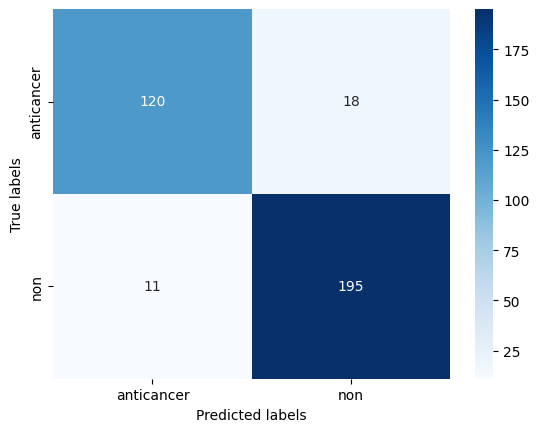

In [16]:
y_pred = cross_val_predict(best_model, X, y, cv=10)

cm = confusion_matrix(y, y_pred)

labels = np.unique(y)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig("cm_bow.pdf", bbox_inches='tight')
plt.show()

### TF-IDF

Aqui utilizamos a abordagem com TF-IDF, considerando cada aminoácido como um token, usando Optuna e SVM novamente.

In [17]:
def amino_acid_tokenizer(sequence):
    return list(sequence)

def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e3, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(tokenizer=amino_acid_tokenizer, lowercase=False, token_pattern=None)),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X, y, cv=10, scoring=make_scorer(f1_score, pos_label='anticancer'))

    return np.mean(scores)

X, y = df_seqs["sequence"].to_numpy(), df_seqs["label"].to_list()

sampler = optuna.samplers.TPESampler(seed=0)
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective, n_trials=100)

print("Best hyperparameters:", study2.best_params)
print(f"Best F1-score: {study2.best_value:.4f}")

[I 2024-09-29 20:14:49,568] A new study created in memory with name: no-name-cd016061-c417-4e6c-8fde-4ef4cca12a23
[I 2024-09-29 20:14:50,431] Trial 0 finished with value: 0.7430680506881879 and parameters: {'svm_C': 0.0869604013210559, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7430680506881879.
[I 2024-09-29 20:14:50,977] Trial 1 finished with value: 0.5885700145958767 and parameters: {'svm_C': 106.15904599003998, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7430680506881879.
[I 2024-09-29 20:14:51,265] Trial 2 finished with value: 0.0 and parameters: {'svm_C': 4.35837428774127e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7430680506881879.
[I 2024-09-29 20:14:51,487] Trial 3 finished with value: 0.8512669552669552 and parameters: {'svm_C': 15.574964948467398, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 3 with value: 0.8512669552669552.
[I 2024-09-29 20:14:51,747] Tria

Best hyperparameters: {'svm_C': 1.580461186560495, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}
Best F1-score: 0.8795


Usando os hiperparâmetros do melhor modelo encontrado, reproduzimos ele novamente para verificar outras métricas como F1-score, MCC, Sensitivity, Specificity.

In [18]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, pos_label='anticancer'),
    'mcc': make_scorer(matthews_corrcoef),
    'sensitivity': make_scorer(recall_score, pos_label='anticancer'),
    'specificity': make_scorer(recall_score, pos_label='non')
}

best_params = study2.best_params

best_model = Pipeline([
    ("tfidf", TfidfVectorizer(tokenizer=amino_acid_tokenizer, lowercase=False, token_pattern=None)),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

cv_results = cross_validate(best_model, X, y, cv=10, scoring=scoring)

print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} +- {cv_results['test_accuracy'].std():.4f}")
print(f"F1-score: {cv_results['test_f1'].mean():.4f} +- {cv_results['test_f1'].std():.4f}")
print(f"MCC: {cv_results['test_mcc'].mean():.4f} +- {cv_results['test_mcc'].std():.4f}")
print(f"Sensitivity: {cv_results['test_sensitivity'].mean():.4f} +- {cv_results['test_sensitivity'].std():.4f}")
print(f"Specificity: {cv_results['test_specificity'].mean():.4f} +- {cv_results['test_specificity'].std():.4f}")

Accuracy: 0.9103 +- 0.0531
F1-score: 0.8795 +- 0.0717
MCC: 0.8173 +- 0.1101
Sensitivity: 0.8253 +- 0.0885
Specificity: 0.9662 +- 0.0609


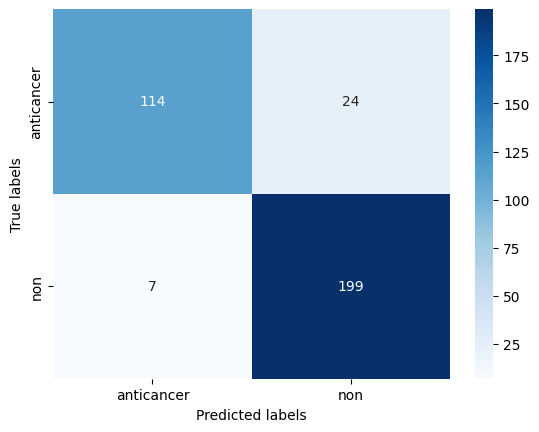

In [20]:
y_pred = cross_val_predict(best_model, X, y, cv=10)

cm = confusion_matrix(y, y_pred)

labels = np.unique(y)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig("cm_tfidf.pdf", bbox_inches='tight')
plt.show()

### Embeddings

Aqui vamos utilizar da abordagem com embeddings. Para isso vamos utilizar de um modelo de linguagem para proteínas pré-treinado 2,1 bilhões de proteínas, o ProtT5-XL-U50. O modelo utiliza da arquitetura Transformer.

In [21]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", do_lower_case=False)

model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
model = model.eval()

def get_embeddings(sequence):
    sequences = [" ".join(list(re.sub(r"[UZOB]", "X", sequence)))]

    ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, pad_to_max_length=True)
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    embedding = embedding.cpu().numpy()

    seq_len = (attention_mask[0] == 1).sum()
    seq_emd = embedding[0][:seq_len-1]

    avg_pool = seq_emd.mean(axis=0)

    dict_embeddings = {f"embedding_{i}": embed for i, embed in enumerate(avg_pool)}

    return dict_embeddings

df_seqs_embeddings = df_seqs.with_columns(pl.col("sequence").map_elements(lambda x: get_embeddings(x)).alias("embeddings")).unnest("embeddings")
df_seqs_embeddings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_l

header,sequence,label,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,…,embedding_987,embedding_988,embedding_989,embedding_990,embedding_991,embedding_992,embedding_993,embedding_994,embedding_995,embedding_996,embedding_997,embedding_998,embedding_999,embedding_1000,embedding_1001,embedding_1002,embedding_1003,embedding_1004,embedding_1005,embedding_1006,embedding_1007,embedding_1008,embedding_1009,embedding_1010,embedding_1011,embedding_1012,embedding_1013,embedding_1014,embedding_1015,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""ACP_1""","""GLWSKIKEVGKEAAKAAAKAAGKAALGAVS…","""anticancer""",-0.019323,-0.002599,0.130414,-0.075928,0.001824,-0.20331,0.021721,-0.094691,-0.109846,-0.034279,-0.065482,-0.020153,-0.160478,-0.091489,0.064163,0.023135,0.098003,-0.030922,0.03341,-0.096055,-0.119683,0.048285,-0.073786,0.065923,0.117198,-0.054174,-0.102073,-0.11074,-0.150871,0.002395,-0.020469,-0.00795,-0.145422,-0.076635,…,0.106716,-0.073939,-0.002574,-0.040431,-0.061274,0.082331,-0.016459,-0.089693,0.027867,-0.041128,-0.088048,-0.152166,0.062855,0.010831,0.01739,0.043263,0.088654,0.130139,0.076391,0.0215,-0.083522,0.045705,-0.016612,0.074871,-0.106587,0.117661,-0.073917,-0.10261,0.076547,0.126747,-0.055616,-0.105252,-0.096375,-0.027492,0.022106,-0.027702,-0.014583
"""ACP_2""","""GLFDIIKKIAESI""","""anticancer""",0.026106,-0.047088,0.055684,-0.054381,0.095308,-0.104832,-0.059624,-0.166802,-0.064655,0.000479,0.021701,-0.006763,-0.272851,0.044901,0.057929,0.210747,0.189701,-0.035808,0.030314,-0.137399,-0.149178,0.163169,-0.037329,-0.028955,0.13306,-0.084929,-0.093998,-0.047631,-0.166771,-0.099899,0.146678,-0.03236,-0.170556,0.06241,…,0.083569,0.011731,0.025899,0.018802,-0.103451,0.117415,0.01803,-0.060621,-0.091746,-0.153904,-0.122273,-0.318796,-0.070174,-0.110321,-0.056395,-0.194036,0.176199,0.132554,-0.004925,0.17127,-0.00089,0.21939,0.117478,0.035164,-0.002884,0.133629,0.126259,-0.019074,0.021489,0.126369,-0.264691,-0.016279,-0.070543,0.072851,0.073174,-0.027636,-0.081745
"""ACP_3""","""GLLDIVKKVVGAFGSL""","""anticancer""",-0.04655,0.026907,0.093185,-0.013867,-0.006329,-0.096084,-0.089391,-0.117143,-0.077145,-0.048794,0.049056,0.001643,-0.316676,0.004841,0.094172,0.113139,0.191189,-0.063296,0.00156,-0.125597,-0.124917,0.159636,-0.036153,0.031103,0.055007,-0.073215,-0.056273,-0.015267,-0.056054,-0.162778,0.052015,-0.042006,-0.164715,0.017658,…,0.053228,0.037828,0.025897,0.030871,-0.058719,0.126066,0.009878,-0.063738,-0.135373,-0.139417,-0.070759,-0.282681,-0.07936,-0.060174,-0.122023,-0.234252,0.238804,0.131539,-0.006006,0.089226,-0.039177,0.095129,0.073832,0.094882,-0.079774,0.096696,0.184683,-0.072877,0.046215,0.039431,-0.210029,-0.121189,-0.03889,-0.014502,0.052977,-0.020669,-0.000186
"""ACP_4""","""GLFDIVKKVVGALGSL""","""anticancer""",-0.050253,0.032823,0.086164,-0.02196,0.002551,-0.116478,-0.09336,-0.10176,-0.090515,-0.045479,0.059444,-0.004367,-0.323056,-0.012521,0.080398,0.136752,0.197317,-0.058988,0.016893,-0.101754,-0.141592,0.151487,-0.036233,0.009952,0.061943,-0.083107,-0.03802,-0.037597,-0.065409,-0.160795,0.03377,-0.041164,-0.163096,0.011319,…,0.064586,0.019812,-0.001945,0.023871,-0.069566,0.131595,-0.012397,-0.061908,-0.13541,-0.139694,-0.10826,-0.28004,-0.056485,-0.063998,-0.

Com a representação em embeddings, vamos utilizar o Optuna com SVM para maximizar a acurácia média do 10-fold Cross-Validation.

In [22]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e3, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X, y, cv=10, scoring=make_scorer(f1_score, pos_label='anticancer'))

    return np.mean(scores)

X, y = df_seqs_embeddings.select(pl.nth(range(3, len(df_seqs_embeddings.columns)))).to_numpy(), df_seqs_embeddings["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study3 = optuna.create_study(direction="maximize", sampler=sampler)
study3.optimize(objective, n_trials=100)

print("Best hyperparameters:", study3.best_params)
print(f"Best F1-score: {study3.best_value:.4f}")

[I 2024-09-29 20:16:39,227] A new study created in memory with name: no-name-58a80338-2b9c-404f-a123-b440de3ba9ed
[I 2024-09-29 20:16:40,029] Trial 0 finished with value: 0.75972764433634 and parameters: {'svm_C': 0.0869604013210559, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.75972764433634.
[I 2024-09-29 20:16:40,209] Trial 1 finished with value: 0.8575379237003263 and parameters: {'svm_C': 106.15904599003998, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 1 with value: 0.8575379237003263.
[I 2024-09-29 20:16:40,677] Trial 2 finished with value: 0.0 and parameters: {'svm_C': 4.35837428774127e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 1 with value: 0.8575379237003263.
[I 2024-09-29 20:16:40,848] Trial 3 finished with value: 0.858694094511186 and parameters: {'svm_C': 15.574964948467398, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 3 with value: 0.858694094511186.
[I 2024-09-29 20:16:41,070] Trial 4 fi

Best hyperparameters: {'svm_C': 0.00027817691684362054, 'svm_gamma': 'scale', 'svm_kernel': 'linear'}
Best F1-score: 0.8853


Usando os hiperparâmetros do melhor modelo encontrado, reproduzimos ele novamente para verificar outras métricas como F1-score, MCC, Sensitivity, Specificity.

In [23]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, pos_label='anticancer'),
    'mcc': make_scorer(matthews_corrcoef),
    'sensitivity': make_scorer(recall_score, pos_label='anticancer'),
    'specificity': make_scorer(recall_score, pos_label='non')
}

best_params = study3.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

cv_results = cross_validate(best_model, X, y, cv=10, scoring=scoring)

print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} +- {cv_results['test_accuracy'].std():.4f}")
print(f"F1-score: {cv_results['test_f1'].mean():.4f} +- {cv_results['test_f1'].std():.4f}")
print(f"MCC: {cv_results['test_mcc'].mean():.4f} +- {cv_results['test_mcc'].std():.4f}")
print(f"Sensitivity: {cv_results['test_sensitivity'].mean():.4f} +- {cv_results['test_sensitivity'].std():.4f}")
print(f"Specificity: {cv_results['test_specificity'].mean():.4f} +- {cv_results['test_specificity'].std():.4f}")

Accuracy: 0.9330 +- 0.0831
F1-score: 0.8853 +- 0.1775
MCC: 0.8639 +- 0.1705
Sensitivity: 0.8286 +- 0.2176
Specificity: 1.0000 +- 0.0000


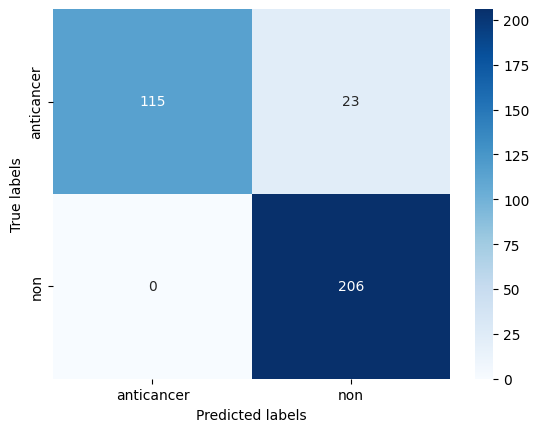

In [24]:
y_pred = cross_val_predict(best_model, X, y, cv=10)

cm = confusion_matrix(y, y_pred)

labels = np.unique(y)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig("cm_embed.pdf", bbox_inches='tight')
plt.show()

### Uso do Conhecimento

Podemos fazer o deploy de um de nossos modelo mais robusto como uma aplicação em Streamlit. Vamos utilizar do modelo baseado em Bag of Words por ter sido o 2º melhor, e ser computacionalmente possível de usar no Streamlit.

In [ ]:
X, y = df_seqs_bow.select(pl.nth(range(3, len(df_seqs_bow.columns)))).to_numpy(), df_seqs_bow["label"].to_numpy()

best_params = study1.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

model = best_model.fit(X, y)

joblib.dump(model, "best_model.pkl")

['best_model.pkl']

O código da aplicação a ser desenvolvido necessitará apenas de fazer a conversão para Bag of Words e utilizar o modelo para predição.